In [1]:
import intake
import cartopy.crs as ccrs
import easygems.healpix as egh
import matplotlib.pyplot as plt


cat = intake.open_catalog("http://data.nextgems-h2020.eu/catalog.yaml")

Text(0, 0.5, '$T_\\mathrm{2m}$ / K')

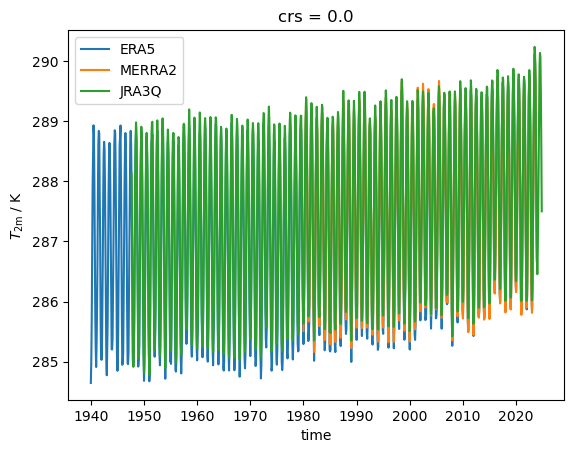

In [8]:
datasets = {
    "ERA5": cat.ERA5.to_dask()["2t"],
    "MERRA2": cat.MERRA2.to_dask()["t2m"],
    "JRA3Q": cat.JRA3Q.to_dask()["mean2t"],
}

fig, ax = plt.subplots()
for label, sst in datasets.items():
    sst.mean("cell").plot(label=label, ax=ax)
ax.legend()
ax.set_ylabel(r"$T_\mathrm{2m}$ / K")

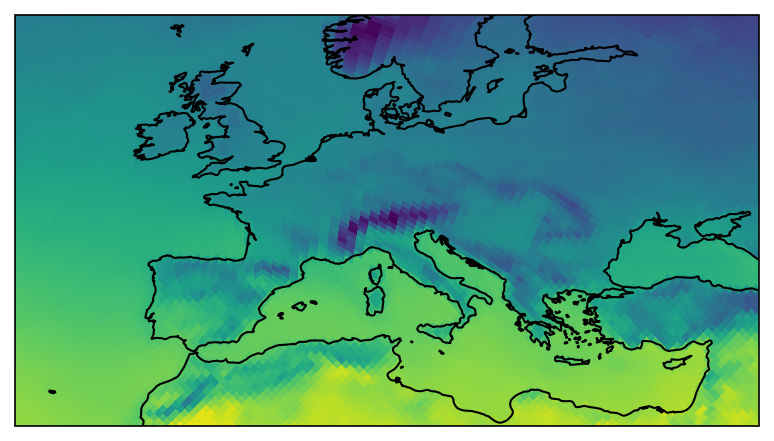

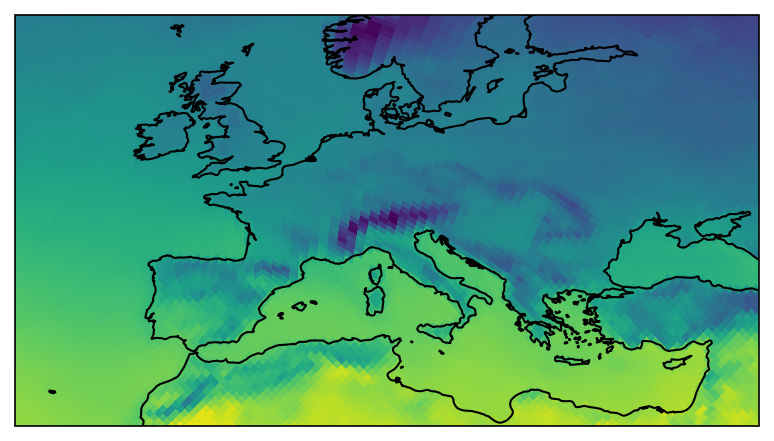

In [9]:
for z in (7, 8):
    ds = cat.ERA5(zoom=z).to_dask()

    fig, ax = plt.subplots(dpi=150, subplot_kw={"projection": ccrs.PlateCarree()})
    ax.set_extent([-20, 40, 30, 60])
    ax.coastlines()
    egh.healpix_show(ds["skt"].sel(time="1991").mean("time"))

Text(0.5, 1.0, '')

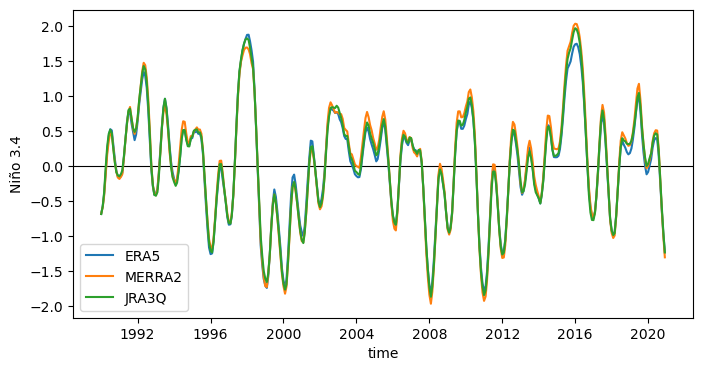

In [10]:
datasets = {
    "ERA5": cat.ERA5.to_dask().skt,
    "MERRA2": cat.MERRA2.to_dask().ts,
    "JRA3Q": cat.JRA3Q.to_dask().msst,
}

fig, ax = plt.subplots(figsize=(8, 4))
ax.axhline(0, color="k", linewidth=0.8)
for label, sst in datasets.items():
    # Spatial mean over Nino region
    nino34 = egh.isel_extent(sst, [-170, -120, -5, 5])
    sst = sst.sel(cell=nino34).mean("cell")
    
    # Compute anomaly to reference period
    sst_ref = sst.sel(time=slice("1991", "2000"))
    sst_anom = (sst - sst_ref.mean("time")) / sst_ref.std("time")
    
    # Plot smoothened Nino index values
    sst_anom.rolling(time=5).mean("time").sel(time=slice("1990", "2020")).plot(label=label, ax=ax)
ax.set_ylabel("Niño 3.4")

ax.legend()
ax.set_title("")